In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from PIL import Image


from gym_battleship.environments.battleship import BattleshipEnv, CHANNEL_MAP

import gym_battleship, inspect
import gym_battleship.environments.battleship as b
print(b.__file__)

/Users/ashritakuppili/Documents/battleship-reinforcement-learning/gym_battleship/environments/battleship.py


In [38]:
import os

REINFORCE_RESULTS_DIR = "./reinforce_models"
os.makedirs(REINFORCE_RESULTS_DIR, exist_ok=True)

In [ ]:
# policy network
class BattleshipPolicyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: (3, 10, 10)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Figure out flattened size
        with torch.no_grad():
            dummy = torch.zeros((1, 3, 10, 10))
            flat_size = self.cnn(dummy).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, 100)   # 10x10 actions
        )

    def forward(self, obs):
        """
        obs: (B, 3, 10, 10)
        returns: probs over 100 actions, shape (B, 100)
        """
        logits = self.fc(self.cnn(obs))      # (B, 100)
        probs = torch.softmax(logits, dim=-1)
        return probs


# action mask from obs

def get_action_mask_from_obs(obs: np.ndarray) -> np.ndarray:
    """
    obs: numpy array shape (3, 10, 10)
    missed: obs[CHANNEL_MAP.MISSED.value]
    hit: obs[CHANNEL_MAP.HIT.value]

    any cell that is missed or hit is illegal (can't shoot there again).
    """
    missed = obs[CHANNEL_MAP.MISSED.value] > 0.5
    hit    = obs[CHANNEL_MAP.HIT.value]    > 0.5
    illegal = missed | hit        # already revealed cells
    legal = ~illegal              # legal = not-revealed
    mask = legal.flatten().astype(np.float32)
    return mask

In [ ]:
# for reinforce agent
class REINFORCEAgent:
    def __init__(self, lr=1e-4, gamma=0.99, device=None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        self.policy = BattleshipPolicyCNN().to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma

        self.saved_log_probs = []
        self.rewards = []

    # training action (stores log-prob)
    def select_action(self, obs, mask=None):
        """
        obs: numpy (3, 10, 10)
        mask: numpy (100,) with 1 for legal, 0 for illegal (optional)
        """
        obs_t = torch.tensor(obs, dtype=torch.float32,
                             device=self.device).unsqueeze(0)  # (1,3,10,10)
        probs = self.policy(obs_t).squeeze(0)  # (100,)

        if mask is not None:
            mask_t = torch.tensor(mask, dtype=torch.float32, device=self.device)
            probs = probs * mask_t
            if probs.sum() <= 0:
                # fallback: uniform over legal
                probs = mask_t / (mask_t.sum() + 1e-8)
            else:
                probs = probs / probs.sum()

        dist = Categorical(probs=probs)
        action = dist.sample()
        self.saved_log_probs.append(dist.log_prob(action))

        return action.item()

    # evaluation action (NO log-prob, greedy)
    def greedy_action(self, obs, mask=None):
        obs_t = torch.tensor(obs, dtype=torch.float32,
                             device=self.device).unsqueeze(0)
        with torch.no_grad():
            probs = self.policy(obs_t).squeeze(0)

        if mask is not None:
            mask_t = torch.tensor(mask, dtype=torch.float32, device=self.device)
            probs = probs * mask_t
            if probs.sum() <= 0:
                probs = mask_t / (mask_t.sum() + 1e-8)
            else:
                probs = probs / probs.sum()

        action = torch.argmax(probs).item()
        return action

    def finish_episode(self):
        """
        standard reinforce update:
        loss = -sum_t log_pi(a_t|s_t) * G_t where G_t is discounted return from time t.
        """
        if len(self.rewards) == 0:
            return

        R = 0
        returns = []

        # compute discounted returns
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        # normalize for stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        loss = 0
        for log_prob, G in zip(self.saved_log_probs, returns):
            loss += -log_prob * G

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # clear episode storage
        self.saved_log_probs = []
        self.rewards = []

In [ ]:
# training logger + plots
class ReinforceTrainingLogger:
    def __init__(self, avg_window=50):
        self.avg_window = avg_window
        self.ep_returns = []
        self.ep_lengths = []
        self.smoothed_returns = []
        self.smoothed_lengths = []
        self.episodes = []

    def log_episode(self, G, length):
        self.ep_returns.append(G)
        self.ep_lengths.append(length)

        if len(self.ep_returns) >= self.avg_window:
            R_mean = np.mean(self.ep_returns[-self.avg_window:])
            L_mean = np.mean(self.ep_lengths[-self.avg_window:])
            self.smoothed_returns.append(R_mean)
            self.smoothed_lengths.append(L_mean)
            self.episodes.append(len(self.ep_returns))

    def plot(self, tag="reinforce"):
        if not self.episodes:
            print("No data logged yet.")
            return

        # reward curve
        fig1, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(self.episodes, self.smoothed_returns, 'b-')
        ax1.set_xlabel("Episode")
        ax1.set_ylabel(f"Mean Return (last {self.avg_window})")
        ax1.set_title("REINFORCE: Training Return")
        ax1.grid(True)
        fig1.tight_layout()
        # fig1.savefig(f"./reinforce_{tag}_reward.png", dpi=150)
        plt.show()
        plt.close(fig1)

        # episode length curve
        fig2, ax2 = plt.subplots(figsize=(10, 5))
        ax2.plot(self.episodes, self.smoothed_lengths, 'r-')
        ax2.set_xlabel("Episode")
        ax2.set_ylabel(f"Mean Episode Length (last {self.avg_window})")
        ax2.set_title("REINFORCE: Episode Length")
        ax2.grid(True)
        fig2.tight_layout()
        # fig2.savefig(f"./reinforce_{tag}_length.png", dpi=150)
        plt.show()
        plt.close(fig2)


Episode    0 | Return:   298.60 | Total wins so far: 1
Episode   50 | Return:   301.80 | Total wins so far: 51
Episode  100 | Return:   300.20 | Total wins so far: 101
Episode  150 | Return:   283.80 | Total wins so far: 151
Episode  200 | Return:   299.80 | Total wins so far: 201
Episode  250 | Return:   313.60 | Total wins so far: 251
Episode  300 | Return:   283.40 | Total wins so far: 301
Episode  350 | Return:   300.80 | Total wins so far: 351
Episode  400 | Return:   314.00 | Total wins so far: 401
Episode  450 | Return:   284.80 | Total wins so far: 451
Episode  500 | Return:   300.40 | Total wins so far: 501
Episode  550 | Return:   314.00 | Total wins so far: 551
Episode  600 | Return:   328.60 | Total wins so far: 601
Episode  650 | Return:   268.40 | Total wins so far: 651
Episode  700 | Return:   268.40 | Total wins so far: 701
Episode  750 | Return:   329.00 | Total wins so far: 751
Episode  800 | Return:   328.40 | Total wins so far: 801
Episode  850 | Return:   331.80 | 

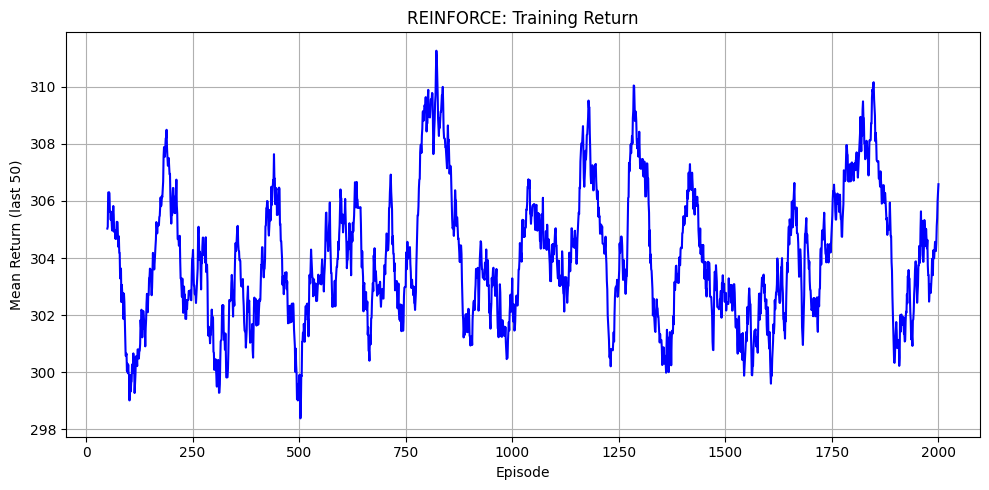

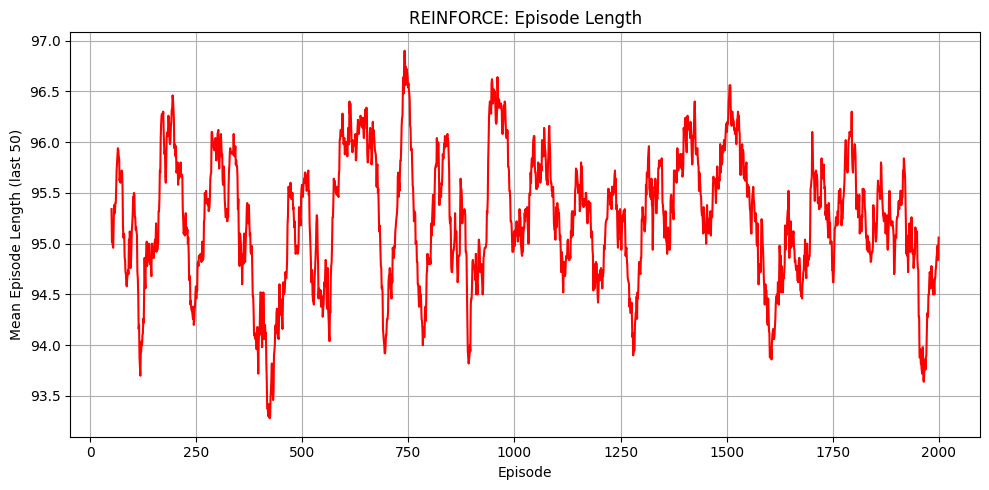

In [42]:
# training loop
reward_dict = {
    'win': 100,
    'lose': -30,
    'missed': -0.2,
    'hit': 5,
    'proximal_hit': 20,
    'repeat_missed': -20,
    'repeat_hit': -3
}

env = BattleshipEnv(reward_dictionary=reward_dict, episode_steps=110)
agent = REINFORCEAgent(lr=1e-4, gamma=0.99)
logger = ReinforceTrainingLogger(avg_window=50)

num_episodes = 2000
wins = 0

for ep in range(num_episodes):
    obs, _ = env.reset()
    done = False
    truncated = False

    ep_return = 0.0
    steps = 0

    while not (done or truncated):
        # use mask during training
        mask = get_action_mask_from_obs(obs)
        action = agent.select_action(obs, mask)
        obs, reward, done, truncated, _ = env.step(action)

        agent.rewards.append(reward)
        ep_return += reward
        steps += 1

    if done:
        wins += 1

    agent.finish_episode()
    logger.log_episode(ep_return, steps)

    if ep % 50 == 0:
        print(f"Episode {ep:4d} | Return: {ep_return:8.2f} | Total wins so far: {wins}")

logger.plot(tag="battleship")

In [ ]:
def masked_policy_predict(agent, obs):
    """
    returns action (int) & probs  (torch tensor of shape (100,))
    (1,3,10,10)
    """
    obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  
    with torch.no_grad():
        probs = agent.policy(obs_t).squeeze(0)  # (100,)

    # apply action mask (can't fire at already seen cells)
    mask = get_action_mask_from_obs(obs)       # numpy (100,)
    mask_t = torch.tensor(mask, dtype=torch.float32)

    probs = probs * mask_t
    if probs.sum() <= 0:
        probs = mask_t / (mask_t.sum() + 1e-8)
    else:
        probs = probs / probs.sum()

    action = torch.argmax(probs).item()
    return action, probs


def plot_prob_heatmap(probs, title="Policy Heatmap for next move", image=False):
    """
    probs: torch tensor or numpy array of shape (100,)
    """
    if isinstance(probs, torch.Tensor):
        probs = probs.cpu().numpy()
    grid = probs.reshape(10, 10)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(grid, cmap='coolwarm', aspect='auto')

    # annotate cells
    for i in range(10):
        for j in range(10):
            ax.text(j, i, f"{grid[i, j]:.2f}",
                    ha="center", va="center", color="black", fontsize=7)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Action Probability', rotation=270, labelpad=15)

    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(title)

    plt.tight_layout()

    if image:
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        img = img[:, :, :3]  # RGBA -> RGB
        plt.close(fig)
        return img
    else:
        plt.show()
        return grid
    
def record_reinforce_video(env, agent, out_path="reinforce-demo.gif", fps=0.5):
    """
    left -> battleship board
    right -> policy probability heatmap for the next move
    """

    def ensure_rgb(img):
        # If env gives RGBA, drop alpha; keep RGB
        if img.ndim == 3 and img.shape[2] == 4:
            return img[:, :, :3]
        return img

    def resize_like(src, ref):
        h, w = ref.shape[:2]
        pil = Image.fromarray(src)
        pil = pil.resize((w, h), Image.BILINEAR)
        return np.array(pil)

    images = []
    obs, info = env.reset()

    board_img = env.unwrapped.render(mode="image")
    board_img = ensure_rgb(board_img)

    _, probs = masked_policy_predict(agent, obs)
    heatmap_img = plot_prob_heatmap(probs, title="Policy Heatmap for next move", image=True)
    heatmap_img = ensure_rgb(heatmap_img)
    heatmap_img = resize_like(heatmap_img, board_img)

    combined = np.concatenate((board_img, heatmap_img), axis=1)
    images.append(combined)

    while True:
        action, probs = masked_policy_predict(agent, obs)
        obs, reward, terminated, truncated, info = env.step(int(action))

        board_img = env.unwrapped.render(mode="image")
        board_img = ensure_rgb(board_img)

        _, next_probs = masked_policy_predict(agent, obs)
        heatmap_img = plot_prob_heatmap(next_probs, title="Policy Heatmap for next move", image=True)
        heatmap_img = ensure_rgb(heatmap_img)
        heatmap_img = resize_like(heatmap_img, board_img)

        combined = np.concatenate((board_img, heatmap_img), axis=1)
        images.append(combined)

        if terminated or truncated:
            break

    imageio.mimsave(out_path, images, fps=fps)
    print(f"Saved REINFORCE video to {out_path}")


In [44]:
record_reinforce_video(env, agent, out_path="reinforce-demo.gif", fps=3)

/Users/ashritakuppili/Documents/battleship-reinforcement-learning/gym_battleship/environments/battleship.py:227: UserWarning: Glyph 11036 (\N{WHITE LARGE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/ashritakuppili/Documents/battleship-reinforcement-learning/gym_battleship/environments/battleship.py:227: UserWarning: Glyph 11036 (\N{WHITE LARGE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/ashritakuppili/Documents/battleship-reinforcement-learning/gym_battleship/environments/battleship.py:227: UserWarning: Glyph 11036 (\N{WHITE LARGE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/ashritakuppili/Documents/battleship-reinforcement-learning/gym_battleship/environments/battleship.py:227: UserWarning: Glyph 11036 (\N{WHITE LARGE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/ashritakuppili/Documents/battleship-reinforcement-learning/gym_battleship/environments/battleship.py:227: UserWarning: Glyph 

Saved REINFORCE video to reinforce-demo.gif


In [ ]:

def run_reinforce_games(agent, env, num_games=1000, use_mask=True):
    """
    retrns stats
    """
    winning_moves = []
    ratios = []
    actions = []
    wins = 0
    total_steps = 0
    total_reward = 0.0

    for g in range(num_games):
        obs, _ = env.reset()
        done = False
        truncated = False
        steps = 0
        hits = 0
        misses = 0
        game_reward = 0.0

        while not (done or truncated):
            if use_mask:
                mask = get_action_mask_from_obs(obs)
                action = agent.greedy_action(obs, mask)
            else:
                action = agent.greedy_action(obs, mask=None)
                actions.append(action)

            obs, reward, done, truncated, _ = env.step(action)

            steps += 1
            game_reward += reward
            if reward > 0:
                hits += 1
            else:
                misses += 1

        if done:
            wins += 1
            winning_moves.append(steps)

        total_steps += steps
        total_reward += game_reward
        ratios.append(hits / misses if misses > 0 else float(hits))

    return {
        "moves_to_win": winning_moves,
        "ratios": ratios,
        "actions": actions,
        "win_rate": wins / num_games,
        "avg_steps_per_game": total_steps / num_games,
        "avg_reward_per_game": total_reward / num_games,
        "avg_hit_miss_ratio": float(np.mean(ratios)) if ratios else 0.0
    }



In [ ]:
def plot_reinforce_histograms(masked_results, tag="reinforce"):
    """
    two histograms:
    1) num of moves to win vs count
    2) hit-to-miss ratio vs count
    using the stats from run_reinforce_games(..., use_mask=True).
    """

    moves = np.array(masked_results["moves_to_win"])
    ratios = np.array(masked_results["ratios"])

    # number of moves to win
    plt.figure(figsize=(7, 5))
    sns.histplot(moves, bins=20, kde=True, color="tab:green")
    plt.title("REINFORCE – Distribution of Moves to Win (Masked)")
    plt.xlabel("Number of Moves to Win")
    plt.ylabel("Count of Games")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # plt.savefig(f"./{tag}_moves_to_win_hist.png", dpi=150)
    plt.show()

    # hit-to-miss ratio 
    plt.figure(figsize=(7, 5))
    sns.histplot(ratios, bins=20, kde=True, color="tab:blue")
    plt.title("REINFORCE – Hit/Miss Ratio Distribution (Masked)")
    plt.xlabel("Hit-to-Miss Ratio")
    plt.ylabel("Count of Games")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # plt.savefig(f"./{tag}_hit_miss_hist.png", dpi=150)
    plt.show()

    print("Moves to win:")
    print(f"  mean = {moves.mean():.2f}, std = {moves.std():.2f}, "
          f"min = {moves.min()}, max = {moves.max()}")
    print("Hit/miss ratio:")
    print(f"  mean = {ratios.mean():.2f}, std = {ratios.std():.2f}, "
          f"min = {ratios.min():.2f}, max = {ratios.max():.2f}")

def plot_eval_stats(masked, unmasked, tag="reinforce"):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    if masked['moves_to_win']:
        sns.histplot(masked['moves_to_win'], kde=True, ax=axes[0,0], color='g')
    axes[0,0].set_title(f"Moves to Win (Masked) - WR: {masked['win_rate']:.1%}")
    axes[0,0].set_xlabel("Moves to Win")
    axes[0,0].set_ylabel("Count")


    sns.histplot(masked['ratios'], kde=True, ax=axes[1,0], color='b')
    axes[1,0].set_title("Hit/Miss Ratio (Masked over 1000 games)")
    axes[1,0].set_xlabel("Hit/Miss Ratio")
    axes[1,0].set_ylabel("Count")


    plt.tight_layout()
    # plt.savefig(f"./reinforce_{tag}_eval.png", dpi=150)
    plt.show()


def save_reinforce_stats(masked_stats, filename="reinforce-training.txt"):
    moves_to_win = masked_stats['moves_to_win']
    avg_moves_to_win = np.mean(moves_to_win) if moves_to_win else float("nan")

    out = "-----------------------------\n"
    out += "REINFORCE Model Results:\n"
    out += f"  Win Rate: {masked_stats['win_rate']:.2%}\n"
    out += f"  Avg Moves to Win: {avg_moves_to_win:.2f}\n"
    out += f"  Avg Steps (All Games): {masked_stats['avg_steps_per_game']:.2f}\n"
    out += f"  Avg Reward: {masked_stats['avg_reward_per_game']:.2f}\n"
    out += f"  Avg Hit/Miss Ratio: {masked_stats['avg_hit_miss_ratio']:.2f}\n"

    print(out)
    with open(filename, "a") as f:
        f.write(out)


-----------------------------
REINFORCE Model Results:
  Win Rate: 100.00%
  Avg Moves to Win: 95.32
  Avg Steps (All Games): 95.32
  Avg Reward: 308.52
  Avg Hit/Miss Ratio: 0.22



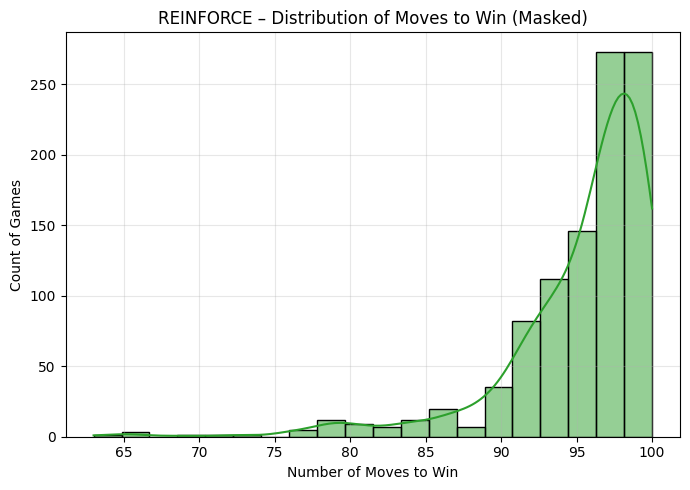

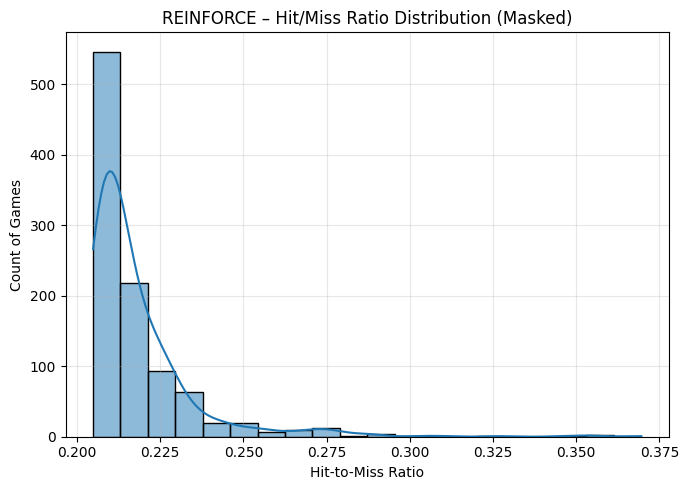

Moves to win:
  mean = 95.32, std = 5.09, min = 63, max = 100
Hit/miss ratio:
  mean = 0.22, std = 0.02, min = 0.20, max = 0.37


In [47]:
# run evaluation

eval_env = BattleshipEnv(reward_dictionary=reward_dict, episode_steps=110)

masked_results = run_reinforce_games(agent, eval_env, num_games=1000, use_mask=True)

save_reinforce_stats(masked_results)

plot_reinforce_histograms(masked_results, tag="reinforce")


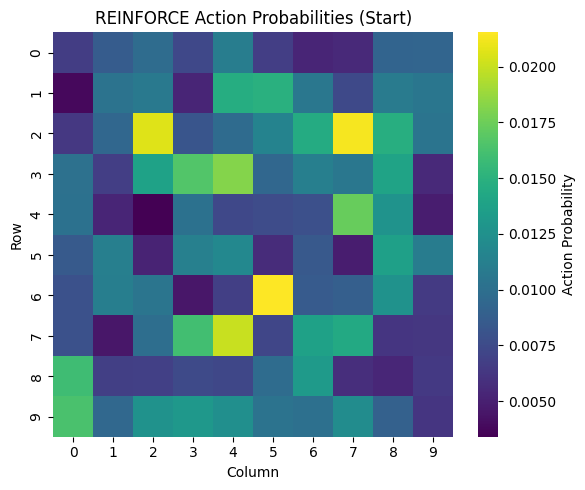

In [ ]:
def plot_policy_heatmap(agent, env, title="REINFORCE Action Probabilities (Start)"):
    """
    plots 10x10 heatmap of the action probabilities for the *initial* board state.
    """
    obs, _ = env.reset()
    obs_t = torch.tensor(obs, dtype=torch.float32,
                         device=agent.device).unsqueeze(0)
    with torch.no_grad():
        probs = agent.policy(obs_t).squeeze(0).cpu().numpy()  # (100,)

    prob_grid = probs.reshape(10, 10)

    plt.figure(figsize=(6, 5))
    sns.heatmap(prob_grid, annot=False, cmap="viridis",
                cbar_kws={"label": "Action Probability"})
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.tight_layout()
    # plt.savefig("./reinforce_policy_heatmap.png", dpi=150)
    plt.show()

plot_policy_heatmap(agent, eval_env)


In [49]:
torch.save(
    agent.policy.state_dict(),
    f"{REINFORCE_RESULTS_DIR}/reinforce_policy.pt"
)
print("Saved REINFORCE policy to", f"{REINFORCE_RESULTS_DIR}/reinforce_policy.pt")

Saved REINFORCE policy to ./reinforce_models/reinforce_policy.pt
